<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling of Israeli Movies Synopses - Digital Humanities Mini Project

In this project, we explore the hidden structures of ±1000 IMDB movies, originated in Israel, based on their synopses content.
Summary of the machine learning flow:

* **Problem statement:**	Unsupervised classification on given movie synopses by NLP
* **Data preprocessing:**	Tokenization and stemming
* **Model training:**	Latent Dirichlet Allocation (LDA) for topic modeling
* **Evaluation:**	main question: Have movie topics, in the Israeli Movie industry, changed over the years?
* **Result:**	Visualiztion of words in each topic, their intertopic distance and the classification of topic to years

The input dataset contains synopses for [IMDB's Feature Films originated in Israel](https://www.imdb.com/search/title/?title_type=feature&countries=il&start=1&ref_=adv_nxt). Each synopsis, or document, is encoded by vector denoting the weight of tokens, which can represent a word or word collection formulated by Bag-of-words model and N-gram model. The weight of each token is determined by the frequency of the term. In the feature engineering stage, each document can be vectorized by the distribution of words.
We adopt Latent Dirichlet Allocation (LDA) to include semantic relation and extract hidden topics.



## Part 1: Load Data from IMDb

**Attention: This stage should run only once to collect data!!! Once the dataset is ready, we can use it by uploading it in the relevant place**

In [ ]:
!pip install cinemagoer
!pip install wikipedia

import re
import pandas as pd
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import numpy as np
from imdb import Cinemagoer
import time
import tqdm

In [ ]:
ia = Cinemagoer()
data = []

In [ ]:
def getMovieId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

In [ ]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
  i = 0
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)

    # Movie id
    id = getMovieId(image)
        
    # Movie release year
    year = getReleaseYear(header)

    # Movie Synopsys
    synopsis = getSynopsisFromImdb(id)

    # Genre
    genre = getGenre(muted_text)

    data.append({'IMDb_id': id, 'Title': movie_title, 'Year': year, 'Genre': genre, 'Synopsis': synopsis})

In [ ]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 2

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

In [ ]:
df = pd.DataFrame(data)
# save data
df.to_csv('israel_originated_movies_imdb.csv')

### Load Synopses from Wikipedia

In [ ]:
import wikipedia

wiki_title = []
wiki_plot = []
wiki_summary = []

In [ ]:
def find_title_on_wikipedia(title, year):
    search_results = wikipedia.search(title, results=20)
    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    return title

def add_wikipedia(data):
  for i in range (len(data)):
    imdb_title = data['English Title'][i]
    year = data['Year'][i]
    title, page, summary = np.nan, np.nan, np.nan

    title = find_title_on_wikipedia(imdb_title, year)
    
    if title != None or title != np.nan:
      page = wikipedia.WikipediaPage(title = title)

      if page != None or page != np.nan:
        summary = page.summary

    wiki_title.append(title)
    wiki_summary.append(summary)


In [ ]:
data = pd.read_csv('israel_originated_movies_imdb_cleared.csv')
add_wikipedia(data)
data['Wiki Title'] = wiki_title
data['Wiki Summary'] = wiki_summary

In [ ]:
data.to_csv('israel_originated_movies_imdb_with_wiki.csv')
data

## Part 2: Text Preprocessing

In [ ]:
!pip install pyLDAvis
!pip install swifter

from pydoc import synopsis
from dateutil.parser import parse
import concurrent.futures
import json
import re
import glob
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

clean year representation. Records with null values removed as well

In [10]:
cleared_data = pd.read_csv('israel_originated_movies_imdb.csv').dropna()
cleared_data = cleared_data[cleared_data.Year != '(III']
cleared_data = cleared_data[cleared_data.Year != '(LX']
cleared_data = cleared_data[cleared_data.Year != '(II']
cleared_data = cleared_data[cleared_data.Year != '(I']
cleared_data = cleared_data[cleared_data.Year != '(V']
cleared_data = cleared_data[cleared_data.Year != '(VII']
cleared_data = cleared_data[cleared_data.Year != '(VI']
cleared_data = cleared_data[cleared_data.Year != '(X']
cleared_data = cleared_data[cleared_data.Year != 'XXXI']

cleared_data.to_csv('ready_for_topic_modeling.csv', index=False)

cleared_data

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis
0,0,3605418,Knock Knock,2015,"Drama, Thriller",A devoted father helps two stranded young wome...
1,1,95182,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...
2,2,9100054,The Lost Daughter,2021,Drama,A woman's beach vacation takes a dark turn whe...
3,3,6896536,Foxtrot,2017,Drama,A troubled family must face the facts when som...
4,4,90859,Cobra,1986,"Action, Crime, Thriller",A tough-on-crime street cop must protect the o...
...,...,...,...,...,...,...
1461,1461,2388797,Up the Wrong Tree,2013,Drama,"This is the story of Nits, a restless bum and ..."
1463,1463,138884,Transit,1980,Drama,A Jewish refugee in Israel
1464,1464,21249770,Marionette,2019,Drama,'Marionette' is a human comedy-drama focused o...
1466,1466,1826755,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider..."


 Tokenize and Clean quotes, new line, verbs etc.

In [11]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [12]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv')

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))

---Doing pre-processing for Synopsis..
Initial pre-processing..


Build the Bigram, Trigram Models and Lemmatize

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['israeli','israelis', 'film', 'films', 'story', 'movie', 'movies', 'year'])
print ('We use {} stop-words from nltk library.'.format(str(len(stopwords))))
print ('First ten stop-words are {}'.format(stopwords[:10]))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

We use 187 stop-words from nltk library.
First ten stop-words are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [14]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1052 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed
0,0,3605418,Knock Knock,2015,"Drama, Thriller",A devoted father helps two stranded young wome...,"[father, strand, young, woman, door, kind, ges...",father strand young woman door kind gesture da...
1,1,95182,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...,"[children, musical, grimms, fairy, tale, frog,...",children musical grimms fairy tale frog king y...
2,2,9100054,The Lost Daughter,2021,Drama,A woman's beach vacation takes a dark turn whe...,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past
3,3,6896536,Foxtrot,2017,Drama,A troubled family must face the facts when som...,"[troubled, family, fact, terribly, wrong, son,...",troubled family fact terribly wrong son milita...
4,4,90859,Cobra,1986,"Action, Crime, Thriller",A tough-on-crime street cop must protect the o...,"[tough, cop, witness, murderous, cult, far, re...",tough cop witness murderous cult far reach plan
...,...,...,...,...,...,...,...,...
1047,1461,2388797,Up the Wrong Tree,2013,Drama,"This is the story of Nits, a restless bum and ...","[nit, restless, hopeless, cynic, journey, obse...",nit restless hopeless cynic journey obsessive ...
1048,1463,138884,Transit,1980,Drama,A Jewish refugee in Israel,[],
1049,1464,21249770,Marionette,2019,Drama,'Marionette' is a human comedy-drama focused o...,"[marionette, human, comedy, drama, navon, mili...",marionette human comedy drama navon military r...
1050,1466,1826755,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider...","[encounter, people, outsider, normal, society,...",encounter people outsider normal society painf...


#### Most common words


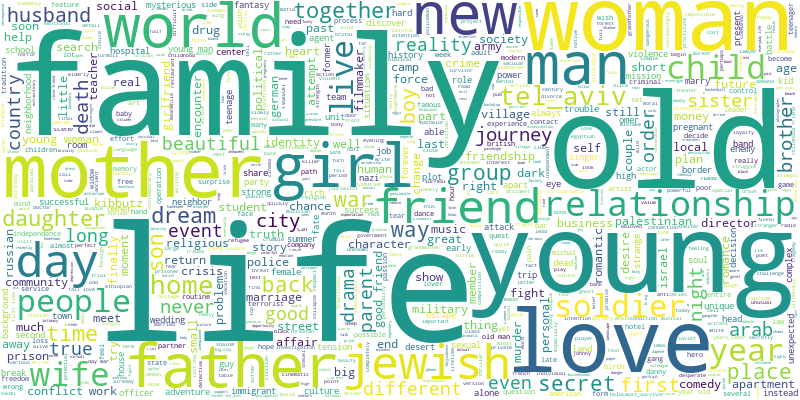

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Part 3: Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [15]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [45]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

## Part 4: Evaluation

In this section we will try to answer the question
> **Have movie topics, in the Israeli Movie industry, changed over the years?**

In [46]:
lda_model.print_topics()

[(0,
  '0.012*"soldier" + 0.011*"young" + 0.010*"agent" + 0.009*"life" + 0.009*"jewish" + 0.007*"woman" + 0.007*"old" + 0.007*"unit" + 0.006*"secret" + 0.006*"female"'),
 (1,
  '0.016*"young" + 0.013*"girl" + 0.012*"life" + 0.011*"father" + 0.009*"woman" + 0.008*"family" + 0.008*"relationship" + 0.008*"day" + 0.008*"love" + 0.006*"old"'),
 (2,
  '0.012*"young" + 0.012*"love" + 0.010*"life" + 0.010*"old" + 0.007*"day" + 0.006*"child" + 0.006*"way" + 0.006*"woman" + 0.005*"relationship" + 0.005*"man"'),
 (3,
  '0.018*"family" + 0.011*"life" + 0.010*"old" + 0.007*"community" + 0.007*"day" + 0.006*"year" + 0.006*"home" + 0.006*"live" + 0.006*"world" + 0.005*"secret"'),
 (4,
  '0.027*"life" + 0.016*"woman" + 0.009*"young" + 0.009*"old" + 0.008*"family" + 0.008*"mother" + 0.007*"relationship" + 0.007*"man" + 0.007*"day" + 0.007*"dream"'),
 (5,
  '0.014*"family" + 0.013*"old" + 0.010*"friend" + 0.010*"young" + 0.009*"new" + 0.009*"wife" + 0.008*"father" + 0.007*"past" + 0.007*"life" + 0.006*"

Assign Dominant Topic to each record

In [47]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

del ready_data['i']
ready_data = ready_data.sort_values(by=[f'{source}_topic'])
ready_data

Pandas Apply:   0%|          | 0/1052 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed,Synopsis_topic
647,719,67101,Fishke Goes to War,1971,"Comedy, Drama",Israel's top secret unit receives a new soldie...,"[israel, top, secret, unit, new, soldier, sold...",israel top secret unit new soldier soldier rab...,0
988,1284,2980430,Placebo,2013,Drama,Alfred spent years as a patient in a mental in...,"[spend, year, patient, mental, institution, ro...",spend year patient mental institution routine ...,0
566,611,2176378,Not in Tel Aviv,2012,"Comedy, Crime, Drama",When a repressed high-school teacher loses his...,"[teacher, job, entire, life, span, day, teenag...",teacher job entire life span day teenage stude...,0
288,295,77428,It Rained All Night the Day I Left,1980,"Comedy, Crime",A tough rich female ranch owner in Africa want...,"[tough, rich, female, ranch, supply, local, re...",tough rich female ranch supply local responsib...,0
256,261,111670,Warriors,1994,"Action, Drama",A government-trained killing machine must turn...,"[government, train, machine, lethal, skill, to...",government train machine lethal skill top secr...,0
...,...,...,...,...,...,...,...,...,...
779,888,1404096,Ruin,2009,"Crime, Drama, Thriller",Three teenage murderers escape to a secluded r...,"[teenage, murderer, ruin, huge, gap, ideologic...",teenage murderer ruin huge gap ideological rom...,9
56,57,1366409,Miral,2010,"Drama, History",A drama centered on an orphaned Palestinian gi...,"[drama, palestinian, girl, wake, arab, war, co...",drama palestinian girl wake arab war conflict,9
470,494,151545,Messagest Hatzameret,1981,"Comedy, Drama","A masseur has very capable ""electrical"" hands ...","[masseur, capable, electrical, hand, woman, sp...",masseur capable electrical hand woman special ...,9
434,453,1927176,InContact,2012,Music,This video artwork follows two women on a fict...,"[video, artwork, woman, fictitious, social, me...",video artwork woman fictitious social medium p...,9


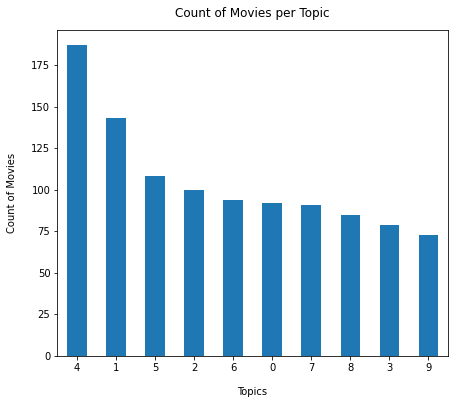

In [48]:
ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

movies age AVG per 

In [49]:
# ready_data.groupby(f'{source}_topic')['Year'].mean()
# ready_data
# test = ready_data[f'{source}_topic']['Year']
test = ready_data.copy()
test = test.drop(columns=['IMDb_id', 'Title', 'Synopsis', 'Synopsis_lemmatized', 'Synopsis_preprocessed', 'Genre', 'Unnamed: 0'])
test.groupby(f'{source}_topic')['Year'].mean()

# test.groupby(by = f'{source}_topic').mean().plot(kind='pie', y='Year', subplots=True)
# test.groupby(f'{source}_topic')['Year'].mean().hist()


Synopsis_topic
0    1999.804348
1    2001.762238
2    2000.860000
3    2005.000000
4    2006.566845
5    2001.055556
6    2000.010638
7    2002.615385
8    2004.129412
9    1998.808219
Name: Year, dtype: float64

In [50]:
test2 = ready_data.copy()
test2 = test2.drop(columns=['IMDb_id', 'Title', 'Synopsis', 'Synopsis_lemmatized', 'Synopsis_preprocessed', 'Year', 'Unnamed: 0'])
test2.groupby(f'{source}_topic')['Genre'].value_counts()

# ready_data.groupby('Genre').sum().plot.pie(y='Genre', figsize=(15,5))

Synopsis_topic  Genre              
0               Drama                  44
                Comedy                  6
                Comedy, Drama           5
                Drama, War              4
                Drama, Thriller         3
                                       ..
9               Drama, Romance, War     1
                Drama, Thriller         1
                Music                   1
                Musical                 1
                Thriller                1
Name: Genre, Length: 342, dtype: int64

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

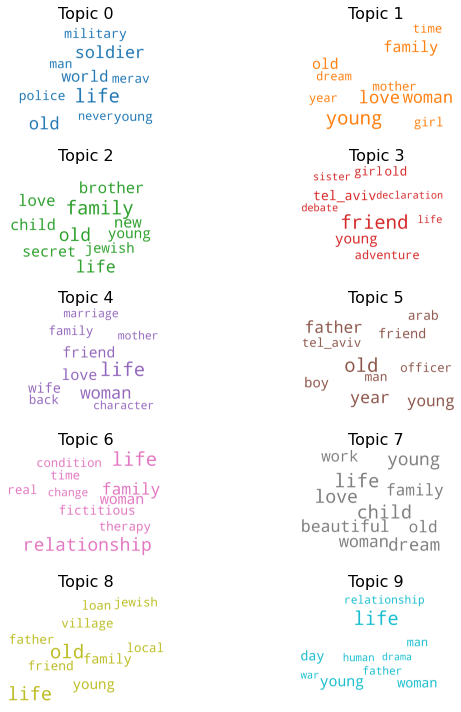

In [43]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.033227  0.157767       1        1  13.841184
4     -0.052376 -0.052834       2        1  13.581150
2     -0.017566 -0.043705       3        1  12.383368
9      0.023926 -0.069573       4        1  11.698957
1     -0.032047 -0.010077       5        1  10.468994
3     -0.031232 -0.018945       6        1   8.856648
5     -0.044403 -0.061144       7        1   8.391058
7     -0.002443  0.017108       8        1   8.115404
0      0.216795  0.008257       9        1   6.475609
6     -0.027426  0.073146      10        1   6.187628, topic_info=              Term        Freq       Total Category  logprob  loglift
184         friend  108.000000  108.000000  Default  30.0000  30.0000
36            life  224.000000  224.000000  Default  29.0000  29.0000
4          soldier   60.000000   60.000000  Default  28.0000  28.0000
2     relationship   80.000000   80.000000  Default  27.0000  27.0000
3329          loan   15.000000   15.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
711            day    4.179069   76.236384  Topic10  -5.6120  -0.1211
1175       reality    3.864871   32.672335  Topic10  -5.6902   0.6480
135        partner    3.822701   12.152262  Topic10  -5.7011   1.6261
212          first    3.838889   42.373993  Topic10  -5.6969   0.3813
1319        sexual    3.835296   21.339924  Topic10  -5.6979   1.0663

[699 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2519      8  0.814586   ability
2519     10  0.101823   ability
4548      1  0.910635  abruptly
619       7  0.739523     abuse
1099      2  0.605181  accident
...     ...       ...       ...
9         8  0.067094     young
9         9  0.054895     young
9        10  0.006099     young
3583      7  0.859656    zidane
4538      3  0.779186      zion

[1478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 3, 10, 2, 4, 6, 8, 1, 7])

## Part 5: Conclusions

1. Most of the movies where assosiated to topic 4 which also has the latest average year (2006).
2. The least number of movies where assosiated to topic 9 which also has the oldest average year (1998) and seem to be related to Musical Drama Genres.
4. There seems to be a great correlation between topics 2-8.
3. Wikipedia does not gives as extra information regarding Israeli movies.